<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-подготовка" data-toc-modified-id="Загрузка-данных-и-подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Подготовка-к-обучению" data-toc-modified-id="Подготовка-к-обучению-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к обучению</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

<h1>Проект для «Викишоп»<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

### Загрузка данных и подготовка

In [1]:
import time
from tqdm.notebook import tqdm_notebook as tqdm

import re
import pandas as pd


from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

In [2]:
try:
    data = pd.read_csv('C:/data_sets/toxic_comments.csv')

except:
     data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
#Напишем функцию для получения информации о датасете

def status_data(data):

    print(data.head())
    print()
    print('Информация о датасете: ')
    print(data.info())
    print('------------------------')
    print('Количество пропусков в данных')
    print(data.isna().sum())
    print('------------------------')
    print('Количество дупликатов в данных:', data.duplicated().sum())
    print('------------------------')
    print(data.describe())

In [4]:
status_data(data)

   Unnamed: 0                                               text  toxic
0           0  Explanation\nWhy the edits made under my usern...      0
1           1  D'aww! He matches this background colour I'm s...      0
2           2  Hey man, I'm really not trying to edit war. It...      0
3           3  "\nMore\nI can't make any real suggestions on ...      0
4           4  You, sir, are my hero. Any chance you remember...      0

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None
------------------------
Количество пропусков в данных
Unnamed: 0    0
text          0
toxic         0
dtype: int64
------------------------
Количество дупликатов в данных: 

Данные в порядке. Пропусков и дубликатов нет. Можно приступать к анализу

### Анализ

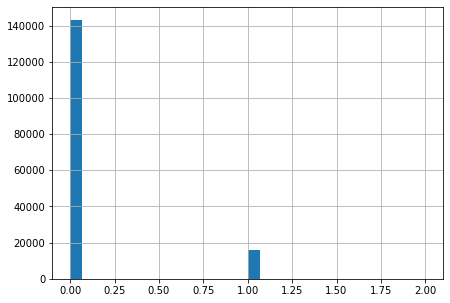

In [5]:
data['toxic'].hist(bins=30,range=(0,2),figsize=(7,5));

Назначим для каждого вида комментария свою категорию и сделаем визуализацию через wordcloud

In [6]:
typical_text = data[data.toxic==0]
toxic_text = data[data.toxic==1]

In [7]:
all_words = " ".join(review for review in data.text)
normal_words = " ".join(review for review in typical_text.text)
toxic_words = " ".join(review for review in toxic_text.text)

In [8]:
%time

cloud_all = WordCloud(max_font_size=50, max_words=70, background_color="gray").generate(all_words)
cloud_normal = WordCloud(max_font_size=50, max_words=70, background_color="gray").generate(normal_words)
cloud_toxic = WordCloud(max_font_size=50, max_words=70, background_color="gray").generate(toxic_words)

CPU times: total: 0 ns
Wall time: 0 ns


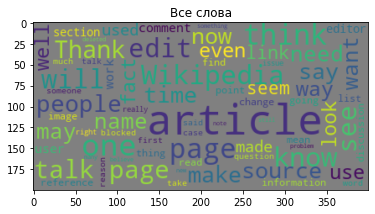

In [9]:
plt.title('Все слова')
plt.imshow(cloud_all, interpolation='bilinear');

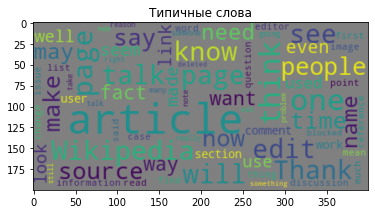

In [10]:
plt.title('Типичные слова')
plt.imshow(cloud_normal, interpolation='bilinear');

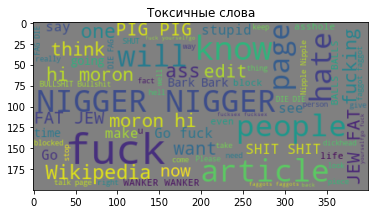

In [11]:
plt.title('Токсичные слова')
plt.imshow(cloud_toxic, interpolation='bilinear');

Некоторые слова встречаются во всех категориях. Такие слова как 'article','wikipedia','page' часто попадают во все категории сразу.

### Подготовка к обучению

**Что необходимо сделать:**

- Удалим знаки пунктуации, оставив только латинские буквы
- Токенизация — преобразование предложений в список слов
- Удалим стоп-слова
- Произведём лемматизацию слов
- Соберём слова обратно в предложение, разделив пробелами
- Приведем слова к нижнему регистру

In [12]:
def text_preprocesing(text, stop_words=None, lemmatize=True, stemming=False):
    words = re.sub(r'[^a-z]', ' ', text.lower()).split()
    if stop_words:
        words = [w for w in words if not w in stop_words]
    if lemmatize:
        wnl = WordNetLemmatizer()
        words = [wnl.lemmatize(w) for w in words]
    if stemming:
        stm = SnowballStemmer('english')
        words = [stm.stem(w) for w in words]
    return ' '.join(words)

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Александр\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
%%time
corpus = data['text'].apply(text_preprocesing, stop_words=stop_words)

X_train, X_test, y_train, y_test = (
    train_test_split(corpus, data['toxic'], test_size=0.3, random_state=12345))

CPU times: total: 21 s
Wall time: 21.1 s


### Обучение моделей

In [15]:
models = []

In [16]:
cv_params = {'scoring': 'f1',
             'return_train_score': True,
             'cv': 3}

In [17]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', LogisticRegression(class_weight='balanced', 
                                            random_state=12345, 
                                            max_iter=500))
                ])
params = {'clf__solver': ['lbfgs', 'liblinear'],
          'clf__C': [0.1, 1, 10]
         } 
grid_lr = GridSearchCV(pipe, params, **cv_params, n_jobs=-1)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)
print(grid_lr.best_score_)

{'clf__C': 10, 'clf__solver': 'lbfgs'}
0.7617745243954209
CPU times: total: 33.5 s
Wall time: 55.7 s


In [18]:
models.append(['LogisticRegression', grid_lr.best_score_])

In [19]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', DecisionTreeClassifier(random_state=12345))])

params = {'clf__max_depth':[5, 10, 15],
          'clf__criterion':['gini','entropy']
         }
grid_dtc = GridSearchCV(pipe, params, **cv_params)
grid_dtc.fit(X_train, y_train)
print(grid_dtc.best_params_)
print(grid_dtc.best_score_)

{'clf__criterion': 'gini', 'clf__max_depth': 15}
0.6413277966788012
CPU times: total: 2min 19s
Wall time: 2min 19s


In [20]:
models.append(['DecisionTreeClassifier', grid_dtc.best_score_])

In [21]:
%%time
pipe = Pipeline([('vct', TfidfVectorizer(min_df=1e-5)),
                 ('clf', RandomForestClassifier(class_weight='balanced',random_state=12345))
                ])

params = {"clf__n_estimators": [100,200,300],
          "clf__max_depth": [5,10,15]
         }
grid_RFC = GridSearchCV(pipe, params, **cv_params)
grid_RFC.fit(X_train, y_train)
print(grid_RFC.best_params_)
print(grid_RFC.best_score_)

{'clf__max_depth': 15, 'clf__n_estimators': 300}
0.401218956944634
CPU times: total: 5min 32s
Wall time: 5min 33s


In [22]:
models.append(['RandomForestClassifier', grid_RFC.best_score_])

In [23]:
result_edu = pd.DataFrame(models, columns=['model', 'f1_score'])
display(result_edu.sort_values(by='f1_score',ascending=False))

,model,f1_score
0,LogisticRegression,0.761775
1,DecisionTreeClassifier,0.641328
2,RandomForestClassifier,0.401219


По результататм обучения наилучшая метрика F1_score у модели Logistic regression. Обучим Logistic regression с лучшими параметрами на тренировочном датасете.

In [24]:
best_model =f1_score(y_test, grid_lr.predict(X_test))

In [25]:
print("Результат LogisticRegression", best_model)

Результат LogisticRegression 0.7623158487379187


### Вывод

**Проведена предобработка текста:**

- Удалены знаки пунктуации
- Удалены стоп-слова
- Применена токенизация
- Слова приведены к нижнему регистру
- Применена лемматизация

В результате обучения получили следующие данные метрик F1 для разных моделей:

- LogisticRegression	0.761775
- DecisionTreeClassifier	0.641328
- RandomForestClassifier	0.401219

Т.к разница между моделями была очень существенна для тестирования была выбрана LogisticRegression

Лучшая модель была протестирована на тестовой выборке и показала метрику 0.7623158487379187 **с учетом баланса классов** и обратная **сила регуляризации равная = 10**, алгоритм **lbfgs**